In [1]:
from IPython.display import Image

# CNTK 102:  Feed Forward Network with Simulated Data

The purpose of this tutorial is to familiarize you with quickly combining components from the CNTK python library to perform a **classification** task. You may skip *Introduction* section, if you have already completed the Logistic Regression tutorial or are familiar with machine learning. 

## Introduction

**Problem** (recap from CNTK 101):

A cancer hospital has provided data and wants us to determine if a patient has a fatal [malignant][] cancer vs. a benign growth. This is known as a classification problem. To help classify each patient, we are given their age and the size of the tumor. Intuitively, one can imagine that younger patients and/or patient with small tumor size are less likely to have malignant cancer. The data set simulates this application where the each observation is a patient represented as a dot where red color indicates malignant and blue indicates a benign disease. Note: This is a toy example for learning, in real life there are large number of features from different tests/examination sources and doctors'  experience that play into the diagnosis/treatment decision for a patient.
[malignant]: https://en.wikipedia.org/wiki/Malignancy

In [2]:
# Figure 1
Image(url="https://www.cntk.ai/jup/cancer_data_plot.jpg", width=400, height=400)

**Goal**:
Our goal is to learn a classifier that classifies any patient into either benign or malignant category given two features (age, tumor size). 

In CNTK 101 tutorial, we learnt a linear classifier using Logistic Regression which misclassified some data points. Often in real world problems, linear classifiers cannot accurately model the data in situations where there is little to no knowledge of how to construct good features. This often results in accuracy limitations and requires models that have more complex decision boundaries. In this tutorial, we will combine multiple linear units (from the CNTK 101 tutorial - Logistic Regression) to a non-linear classifier. The other aspect of such classifiers where the feature encoders are automatically learnt from the data will be covered in later tutorials.  

**Approach**:
Any learning algorithm has typically five stages. These are Data reading, Data preprocessing, Creating a model, Learning the model parameters, and Evaluating (a.k.a. testing/prediction) the model. 

We keep everything same as CNTK 101 except for the third (Model creation) step where we use a feed forward network instead.
 

## Feed forward network model

The data set used is similar to the one used in the Logistic Regression tutorial. The model combines multiple logistic classifiers to be able to classify data when the decision boundary needed to properly categorize the data is more complex than a simple linear model (like Logistic Regression). The figure below illustrates the general shape of the network.

In [3]:
# Figure 2
Image(url="https://upload.wikimedia.org/wikipedia/en/5/54/Feed_forward_neural_net.gif", width=200, height=200)

A feedforward neural network is an artificial neural network where connections between the units **do not** form a cycle.
The feedforward neural network was the first and simplest type of artificial neural network devised. In this network, the information moves in only one direction, forward, from the input nodes, through the hidden nodes (if any) and to the output nodes. There are no cycles or loops in the network

In this tutorial, we will go through the different steps needed to complete the five steps for training and testing a model on the toy data.

In [4]:
# Import the relevant components
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import sys
import os

import cntk as C
from cntk import Trainer, learning_rate_schedule, UnitType, sgd
from cntk.initializer import glorot_uniform
from cntk.layers import default_options, Input, Dense

# Select the right target device when this notebook is being tested:
if 'TEST_DEVICE' in os.environ:
    import cntk
    if os.environ['TEST_DEVICE'] == 'cpu':
        cntk.device.try_set_default_device(cntk.device.cpu())
    else:
        cntk.device.try_set_default_device(cntk.device.gpu(0))

## Data Generation
This section can be *skipped* (next section titled <a href='#Model Creation'>Model Creation</a>) if you have gone through CNTK 101. 

Let us generate some synthetic data emulating the cancer example using `numpy` library. We have two features (represented in two-dimensions)  each either being to one of the two classes (benign:blue dot or malignant:red dot). 

In our example, each observation in the training data has a label (blue or red) corresponding to each observation (set of features - age and size). In this example, we have two classes represented by labels 0 or 1, thus a  binary classification task.

In [5]:
# Ensure we always get the same amount of randomness
np.random.seed(0)

# Define the data dimensions
input_dim = 2
num_output_classes = 2

### Input and Labels

In this tutorial we are generating synthetic data using `numpy` library. In real world problems, one would use a reader, that would read feature values (`features`: *age* and *tumor size*) corresponding to each observation (patient).  Note, each observation can reside in a higher dimension space (when more features are available) and will be represented as a tensor in CNTK. More advanced tutorials shall introduce the handling of high dimensional data.

In [6]:
# Helper function to generate a random data sample
def generate_random_data_sample(sample_size, feature_dim, num_classes):
    # Create synthetic data using NumPy. 
    Y = np.random.randint(size=(sample_size, 1), low=0, high=num_classes)

    # Make sure that the data is separable
    X = (np.random.randn(sample_size, feature_dim)+3) * (Y+1)
    X = X.astype(np.float32)    
    # converting class 0 into the vector "1 0 0", 
    # class 1 into vector "0 1 0", ...
    class_ind = [Y==class_number for class_number in range(num_classes)]
    Y = np.asarray(np.hstack(class_ind), dtype=np.float32)
    return X, Y   

In [7]:
# Create the input variables denoting the features and the label data. Note: the input_variable 
# does not need additional info on number of observations (Samples) since CNTK first create only 
# the network tooplogy first 
mysamplesize = 64
features, labels = generate_random_data_sample(mysamplesize, input_dim, num_output_classes)


Let us visualize the input data. 

**Caution**: If the import of `matplotlib.pyplot` fails, please run `conda install matplotlib` which will fix the `pyplot` version dependencies

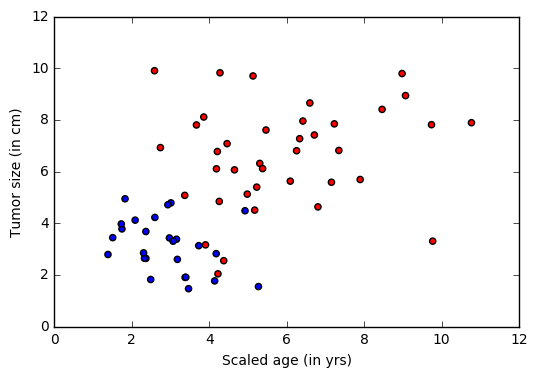

In [8]:
# Plot the data 
import matplotlib.pyplot as plt
%matplotlib inline

# given this is a 2 class 
colors = ['r' if l == 0 else 'b' for l in labels[:,0]]

plt.scatter(features[:,0], features[:,1], c=colors)
plt.xlabel("Scaled age (in yrs)")
plt.ylabel("Tumor size (in cm)")
plt.show()

<a id='#Model Creation'></a>
## Model Creation

Our feed forward network will be relatively simple with 2 hidden layers (`num_hidden_layers`) with each layer having 50 hidden nodes (`hidden_layers_dim`).

In [9]:
# Figure 3
Image(url="http://cntk.ai/jup/feedforward_network.jpg", width=200, height=200)

The number of green nodes (refer to picture above) in each hidden layer is set to 50 in the example and the number of hidden layers (refer to the number of layers of green nodes) is 2. Fill in the following values:
- num_hidden_layers
- hidden_layers_dim

Note: In this illustration, we have not shown the bias node (introduced in the logistic regression tutorial). Each hidden layer would have a bias node.

In [10]:
num_hidden_layers = 2
hidden_layers_dim = 50

Network input and output: 
- **input** variable (a key CNTK concept): 
>An **input** variable is a container in which we fill different observations (data point or sample, equivalent to a blue/red dot in our example) during model learning (a.k.a.training) and model evaluation (a.k.a. testing). Thus, the shape of the `input_variable` must match the shape of the data that will be provided.  For example, when data are images each of  height 10 pixels  and width 5 pixels, the input feature dimension will be two (representing image height and width). Similarly, in our examples the dimensions are age and tumor size, thus `input_dim` = 2). More on data and their dimensions to appear in separate tutorials.


**Question** What is the input dimension of your chosen model? This is fundamental to our understanding of variables in a network or model representation in CNTK.


In [11]:
# The input variable (representing 1 observation, in our example of age and size) $\bf{x}$ which 
# in this case has a dimension of 2. 
#
# The label variable has a dimensionality equal to the number of output classes in our case 2. 
# We use the Input block object equivalent to input_variable.

input = Input(input_dim)
label = Input(num_output_classes)

## Feed forward network setup
Let us define the feedforward network one step at a time. The first layer takes an input feature vector ($\bf{x}$) with dimensions (`input_dim`) say $m$) and emits the output a.k.a. *evidence* (first hidden layer $\bf{z_1}$ with dimension (`hidden_layer_dim`) say $n$). Each feature in the input layer is connected with a node in the output later by the weight which is represented by a matrix $\bf{W}$ with dimensions ($m \times n$). The first step is to compute the evidence for the entire feature set. Note: we use **bold** notations to denote matrix / vectors: 

$$\bf{z_1} = \bf{W} \cdot \bf{x} + \bf{b}$$ 

where $\bf{b}$ is a bias vector of dimension $n$. 

In the `linear_layer` function, we perform two operations:
0. multiply the weights ($\bf{W}$) with the features ($\bf{x}$) and add individual features' contribution,
1. add the bias term $\bf{b}$.

In [12]:
def linear_layer(input_var, output_dim):
    input_dim = input_var.shape[0]
    
    weight = C.parameter(shape=(input_dim, output_dim))
    bias = C.parameter(shape=(output_dim))

    return bias + C.times(input_var, weight)

The next step is to convert the *evidence* (the output of the linear layer) through a non-linear function a.k.a. *activation functions* of your choice that would squash the evidence to activations using a choice of functions ([found here][]). **Sigmoid** or **Tanh** are historically popular. We will use **sigmoid** function in this tutorial. The output of the sigmoid function often is the input to the next layer or the output of the final layer. 
[found here]: https://github.com/Microsoft/CNTK/wiki/Activation-Functions

**Question**: Try different activation functions by passing different them to `nonlinearity` value and get familiarized with using them.

In [13]:
def dense_layer(input_var, output_dim, nonlinearity):
    l = linear_layer(input_var, output_dim)
    
    return nonlinearity(l)

Now that we have created one hidden layer, we need to iterate through the layers to create a fully connected classifier. Output of the first layer $\bf{h_1}$ becomes the input to the next layer.

In this example we have only 2 layers, hence one could conceivably write the code as:

    h1 = dense_layer(input_var, hidden_layer_dim, sigmoid)
    h2 = dense_layer(h1, hidden_layer_dim, sigmoid)


To be more agile when experimenting with the number of layers, we prefer to write it as follows:

    h = dense_layer(input_var, hidden_layer_dim, sigmoid)
    for i in range(1, num_hidden_layers):
        h = dense_layer(h, hidden_layer_dim, sigmoid)

In [14]:
# Define a multilayer feedforward classification model
def fully_connected_classifier_net(input_var, num_output_classes, hidden_layer_dim, 
                                   num_hidden_layers, nonlinearity):
    
    h = dense_layer(input_var, hidden_layer_dim, nonlinearity)
    for i in range(1, num_hidden_layers):
        h = dense_layer(h, hidden_layer_dim, nonlinearity)
    
    return linear_layer(h, num_output_classes)

The network output `z` will be used to represent the output of a network across.

In [15]:
# Create the fully connected classfier
z = fully_connected_classifier_net(input, num_output_classes, hidden_layers_dim, 
                                   num_hidden_layers, C.sigmoid)

While the aforementioned network helps us better understand how to implement a network using CNTK primitives, it is much more convenient and faster to use the [layers library](https://www.cntk.ai/pythondocs/layerref.html). It provides predefined commonly used “layers” (lego like blocks), which simplifies the design of networks that consist of standard layers layered on top of each other. For instance, ``dense_layer`` is already easily accessible through the [`Dense`](https://www.cntk.ai/pythondocs/layerref.html#dense) layer function to compose our deep model. We can pass the input variable (`Input`) to this model to get the network output. 

**Suggested task**: Please go through the model defined above and the output of the `create_model` function and convince that the implementation below encapsulates the code above.

In [16]:
def create_model(features):
    with default_options(init=glorot_uniform(), activation=C.sigmoid):
        h = features
        for _ in range(num_hidden_layers):
            h = Dense(hidden_layers_dim)(h)
        last_layer = Dense(num_output_classes, activation = None)
        
        return last_layer(h)
        
z = create_model(input)

### Learning model parameters

Now that the network is setup, we would like to learn the parameters $\bf W$ and $\bf b$ for each of the layers in our network. To do so we convert, the computed evidence ($\bf z_{final~layer}$) into a set of predicted probabilities ($\textbf p$) using a `softmax` function.

$$ \textbf{p} = \mathrm{softmax}(\bf{z_{final~layer}})$$ 

One can see the `softmax` function as an activation function that maps the accumulated evidences to a probability distribution over the classes (Details of the [softmax function][]). Other choices of activation function can be [found here][].

[softmax function]: https://www.cntk.ai/pythondocs/cntk.ops.html#cntk.ops.softmax

[found here]: https://github.com/Microsoft/CNTK/wiki/Activation-Functions

## Training

If you have already gone through CNTK101, please skip this section and jump to the section titled,
<a href='#Run the trainer'>Run the trainer'</a>.

The output of the `softmax` is a probability of observations belonging to the respective classes. For training the classifier, we need to determine what behavior the model needs to mimic. In other words, we want the generated probabilities to be as close as possible to the observed labels. This function is called the *cost* or *loss* function and shows what is the difference between the learnt model vs. that generated by the training set.

$$ H(p) = - \sum_{j=1}^C y_j \log (p_j) $$  

where $p$ is our predicted probability from `softmax` function and $y$ represents the label. This label provided with the data for training is also called the ground-truth label. In the two-class example, the `label` variable has dimensions of two (equal to the `num_output_classes` or $C$). Generally speaking, if the task in hand requires classification into $C$ different classes, the label variable will have $C$ elements with 0 everywhere except for the class represented by the data point where it will be 1.  Understanding the [details][] of this cross-entropy function is highly recommended.

[`cross-entropy`]: http://cntk.ai/pythondocs/cntk.ops.html#cntk.ops.cross_entropy_with_softmax
[details]: http://colah.github.io/posts/2015-09-Visual-Information/

In [17]:
loss = C.cross_entropy_with_softmax(z, label)

#### Evaluation

In order to evaluate the classification, one can compare the output of the network which for each observation emits a vector of evidences (can be converted into probabilities using `softmax` functions) with dimension equal to number of classes.

In [18]:
eval_error = C.classification_error(z, label)

### Configure training

The trainer strives to reduce the `loss` function by different optimization approaches, [Stochastic Gradient Descent][] (`sgd`) being one of the most popular one. Typically, one would start with random initialization of the model parameters. The `sgd` optimizer would calculate the `loss` or error between the predicted label against the corresponding ground-truth label and using [gradient-decent][] generate a new set model parameters in a single iteration. 

The aforementioned model parameter update using a single observation at a time is attractive since it does not require the entire data set (all observation) to be loaded in memory and also requires gradient computation over fewer datapoints, thus allowing for training on large data sets. However, the updates generated using a single observation sample at a time can vary wildly between iterations. An intermediate ground is to load a small set of observations and use an average of the `loss` or error from that set to update the model parameters. This subset is called a *minibatch*.

With minibatches we often sample observation from the larger training dataset. We repeat the process of model parameters update using different combination of training samples and over a period of time minimize the `loss` (and the error). When the incremental error rates are no longer changing significantly or after a preset number of maximum minibatches to train, we claim that our model is trained.

One of the key parameter for optimization is called the `learning_rate`. For now, we can think of it as a scaling factor that modulates how much we change the parameters in any iteration. We will be covering more details in later tutorial. 
With this information, we are ready to create our trainer.

[optimization]: https://en.wikipedia.org/wiki/Category:Convex_optimization
[Stochastic Gradient Descent]: https://en.wikipedia.org/wiki/Stochastic_gradient_descent
[gradient-decent]: http://www.statisticsviews.com/details/feature/5722691/Getting-to-the-Bottom-of-Regression-with-Gradient-Descent.html

In [19]:
# Instantiate the trainer object to drive the model training
learning_rate = 0.5
lr_schedule = C.learning_rate_schedule(learning_rate, UnitType.minibatch) 
learner = C.sgd(z.parameters, lr_schedule)
trainer = Trainer(z, (loss, eval_error), [learner])

First lets create some helper functions that will be needed to visualize different functions associated with training.

In [20]:
# Define a utility function to compute the moving average sum.
# A more efficient implementation is possible with np.cumsum() function
def moving_average(a, w=10):    
    if len(a) < w: 
        return a[:]    # Need to send a copy of the array
    return [val if idx < w else sum(a[(idx-w):idx])/w for idx, val in enumerate(a)]


# Defines a utility that prints the training progress
def print_training_progress(trainer, mb, frequency, verbose=1):    
    training_loss = "NA"
    eval_error = "NA"

    if mb%frequency == 0:
        training_loss = trainer.previous_minibatch_loss_average
        eval_error = trainer.previous_minibatch_evaluation_average
        if verbose: 
            print ("Minibatch: {}, Train Loss: {}, Train Error: {}".format(mb, training_loss, eval_error))
        
    return mb, training_loss, eval_error

<a id='#Run the trainer'></a>
### Run the trainer

We are now ready to train our fully connected neural net. We want to decide what data we need to feed into the training engine.

In this example, each iteration of the optimizer will work on 25 samples (25 dots w.r.t. the plot above) a.k.a. `minibatch_size`. We would like to train on say 20000 observations. Note: In real world case, we would be given a certain amount of labeled data (in the context of this example, observation (age, size) and what they mean (benign / malignant)). We would use a large number of observations for training say 70% and set aside the remainder for evaluation of the trained model.

With these parameters we can proceed with training our simple feed forward network.

In [21]:
# Initialize the parameters for the trainer
minibatch_size = 25
num_samples = 20000
num_minibatches_to_train = num_samples / minibatch_size

In [22]:
# Run the trainer and perform model training
training_progress_output_freq = 20

plotdata = {"batchsize":[], "loss":[], "error":[]}

for i in range(0, int(num_minibatches_to_train)):
    features, labels = generate_random_data_sample(minibatch_size, input_dim, num_output_classes)
    
    # Specify the input variables mapping in the model to actual minibatch data for training
    trainer.train_minibatch({input : features, label : labels})
    batchsize, loss, error = print_training_progress(trainer, i, 
                                                     training_progress_output_freq, verbose=0)
    
    if not (loss == "NA" or error =="NA"):
        plotdata["batchsize"].append(batchsize)
        plotdata["loss"].append(loss)
        plotdata["error"].append(error)

Let us plot the errors over the different training minibatches. Note that as we iterate the training loss decreases though we do see some intermediate bumps. The bumps indicate that during that iteration the model came across observations that it predicted incorrectly. This can happen with observations that are novel during model training.

One way to smoothen the bumps is by increasing the minibatch size. One could conceptually use the entire data set in every iteration. This would ensure the loss keeps consistently decreasing over iterations. However, this approach  requires the gradient computations over all data points in the dataset and repeat those after locally updating the model parameters for a large number of iterations. For this toy example it is not a big deal. However with real world example, making multiple passes over the entire data set for each iteration of parameter update becomes computationally prohibitive. 

Hence, we use smaller minibatches and using `sgd` enables us to have a great scalability while being performant for large data sets. There are advanced variants of the optimizer unique to CNTK that enable harnessing computational efficiency for real world data sets and will be introduced in advanced tutorials. 

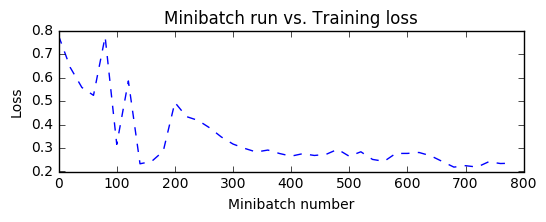

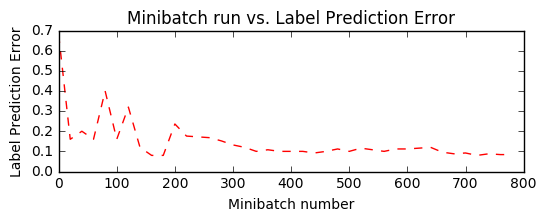

In [23]:
# Compute the moving average loss to smooth out the noise in SGD
plotdata["avgloss"] = moving_average(plotdata["loss"])
plotdata["avgerror"] = moving_average(plotdata["error"])

# Plot the training loss and the training error
import matplotlib.pyplot as plt

plt.figure(1)
plt.subplot(211)
plt.plot(plotdata["batchsize"], plotdata["avgloss"], 'b--')
plt.xlabel('Minibatch number')
plt.ylabel('Loss')
plt.title('Minibatch run vs. Training loss')

plt.show()

plt.subplot(212)
plt.plot(plotdata["batchsize"], plotdata["avgerror"], 'r--')
plt.xlabel('Minibatch number')
plt.ylabel('Label Prediction Error')
plt.title('Minibatch run vs. Label Prediction Error')
plt.show()

## Evaluation / Testing 

Now that we have trained the network, let us evaluate the trained network on data that hasn't been used for training. This is often called **testing**. Let us create some new data set and evaluate the average error and loss on this set. This is done using `trainer.test_minibatch`.

In [24]:
# Generate new data
test_minibatch_size = 25
features, labels = generate_random_data_sample(test_minibatch_size, input_dim, num_output_classes)

trainer.test_minibatch({input : features, label : labels})

0.12

Note, this error is very comparable to our training error indicating that our model has good "out of sample" error a.k.a. generalization error. This implies that our model can very effectively deal with previously unseen observations (during the training process). This is key to avoid the phenomenon of overfitting.

We have so far been dealing with aggregate measures of error. Lets now get the probabilities associated with individual data points. For each observation, the `eval` function returns the probability distribution across all the classes. If you used the default parameters in this tutorial, then it would be a vector of 2 elements per observation. First let us route the network output through a softmax function.

#### Why do we need to route the network output `netout` via `softmax`?

The way we have configured the network includes the output of all the activation nodes (e.g., the green layer in  Figure 4). The output nodes (the orange layer in Figure 4), converts the activations into a probability. A simple and effective way is to route the activations via a softmax function.

In [25]:
# Figure 4
Image(url="http://cntk.ai/jup/feedforward_network.jpg", width=200, height=200)

In [26]:
out = C.softmax(z)

Let us test on previously unseen data.

In [27]:
predicted_label_probs = out.eval({input : features})

In [28]:
print("Label    :", [np.argmax(label) for label in labels])
print("Predicted:", [np.argmax(row) for row in predicted_label_probs])

Label    : [1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1]
Predicted: [18]


**Exploration Suggestion**
-  Try exploring how the classifier behaves with different data distributions - suggest changing the `minibatch_size` parameter from 25 to say 64. What happens to the error rate? How does the error compare to the logistic regression classifier?
- Try exploring different optimizers such as Adam (`fsadagrad`). 
    learner = fsadagrad(z.parameters(), 0.02, 0, targetAdagradAvDenom=1)
- Can you change the network to reduce the training error rate? When do you see *overfitting* happening?

#### Code link

If you want to try running the tutorial from python command prompt. Please run the [FeedForwardNet.py][] example.

[FeedForwardNet.py]: https://github.com/Microsoft/CNTK/blob/v2.0.beta15.0/Tutorials/NumpyInterop/FeedForwardNet.py